In [32]:
import sys
from gurobipy import *
import math
from matplotlib import pyplot as plt

In [69]:
#get data from .jld files
#https://docs.h5py.org/en/stable/high/group.html
#https://docs.h5py.org/en/stable/high/attr.html

import h5py
x1_data = h5py.File("X1.jld", "r")
x2_data = h5py.File("X2.jld", "r")
x3_data = h5py.File("X3.jld", "r")

# simple logic for switching between different instances of the problem (different client locations)
# sets parameters of the problem and loads coordinate data into X (2D array)
    # X[0]: all 25 "x" coordinates
    # X[1]: "y" coordinates

instance = 2 # 1, 2, or 3

if instance == 1:
    #2, 8, 10
    n_min = 2
    n_max = 8
    d_max = 10
    X = [x1_data["X"][0], x1_data["X"][1]]
elif instance == 2:
    #4, 6, 9
    n_min = 4
    n_max = 6
    d_max = 9
    X = [x2_data["X"][0], x2_data["X"][1]]   
elif instance == 3:
    #4, 6, 9
    n_min = 4
    n_max = 6
    d_max = 9 
    X = [x3_data["X"][0], x3_data["X"][1]]
else:
    print("Error: instance needs to be 1, 2, or 3")

n = len(X[0]) 
n #should be 25

25

In [54]:
# Create model
myModel = Model( "ClientDepot_MinClusters" )

# Create variables and put them into arrays for reference in the model:

Y = []
for i in range(n):
    Y.append([])
    for j in range(n):
        Y[i].append(0)
        Y[i][j] = myModel.addVar(lb = 0, ub = 1.0, vtype = GRB.BINARY )
# Y is an assignment matrix:
# Y[i][j] = 1: client i is assigned to depot j, otherwise 0
# each entry of Y is its own decision variable
# NOTE: I always use i (or ii) to index clients and j to index depots

depots = [myModel.addVar(lb = 0, ub = 1.0, vtype = GRB.BINARY ) for j in range(n)]
#depots is a vector that indicates whether a depot has clients assigned to it
#depots[j] = 0: no clients assigned to depot j.
#          = 1: one or more clients assigned to depot j.

D = []
for i in range(n):
    D.append([])
    for ii in range(n):
        D[i].append( math.sqrt((X[0][i] - X[0][ii])**2 + (X[1][i] - X[1][ii])**2) )
# Distance matrix: D[i][ii] is the distance between clients i and ii
#max(D[1])

# update the model to save the variables
myModel.update()

In [55]:
# add objective equation to the model 
# Part (a): MINIMIZE NUMBER OF CLUSTERS (depots)

objExpr = LinExpr()
for j in range(n):
    objExpr += depots[j]

myModel.setObjective( objExpr , GRB.MINIMIZE )

In [57]:
# create expressions for constraints and add to the model

#IMPROVED FIRST CONSTRAINT (2/16/22 after 3 weeks of ORIE 5135 integer programming)
    # we don't need to worry about an upper bound on Y since it is being minimized in the objective function
    # so we only need to ensure that Y[i][j] = 1 ==> depots[j] = 1, not the reverse
    # the former constraint is sufficient, but mathematically dominated by the following formulation:
        # Y[i][j] <= depots[j] for all i, j
firstConst = [[LinExpr() for j in depots] for i in clients] # this is a 2D array
for i in range(n):
    for j in range(n):
        firstConst[i][j] += Y[i][j]
        myModel.addConstr( lhs = firstConst[i][j] , sense = GRB.LESS_EQUAL , rhs = depots[j] )

#SECOND CONSTRAINT: client-depot uniqueness
#ensures that the sum of each row of Y is exactly 1 (each client assigned to one unique depot)
secondConst = [LinExpr() for i in clients]
for i in range(n):
    for j in range(n):
        secondConst[i] += Y[i][j]
    
    myModel.addConstr( lhs = secondConst[i] , sense = GRB.EQUAL , rhs = 1 )

    
#THIRD CONSTRAINT: min and max clients constraint
#the sum of the j-th column of Y must be between n_min and n_max 
#(unless it is empty, i.e. depots[j] = 0)
thirdConst = [LinExpr() for j in depots]
for j in range(n):
    for i in range(n):
        thirdConst[j] += Y[i][j]
        
    myModel.addConstr( lhs = thirdConst[j] , sense = GRB.LESS_EQUAL , rhs = n_max*depots[j] )
    myModel.addConstr( lhs = thirdConst[j] , sense = GRB.GREATER_EQUAL , rhs = n_min*depots[j] )
    
#FOURTH CONSTRAINT: max distance constraint
#ensures that any two clients belonging to the same depot are no further than d_max from each other
for j in range(n):
    
    #Look at each pair of clients i and ii in depot j
    for i in range(n):
        for ii in range(n): 
            
            act = 1e10*(1 - Y[i][j]) + 1e10*(1 - Y[ii][j])
            # act is very large if client i or ii is not in the depot, else 0
            myModel.addConstr( lhs = D[i][ii], sense = GRB.LESS_EQUAL , rhs = d_max + act )
            
            #if Y[i][j] or Y[ii][j] = 0, the constraint will be satisfied automatically (rhs will be very large)
            #if they are both 1, then the constraint is "act"ivated, 
            #so the distance between that pair must be less than d_max

In [58]:
# integrate objective and constraints into the model
myModel.update()
# write the model in a file to make sure it is constructed correctly
myModel.write( filename = "testOutput_A.lp" )
# optimize the model
myModel.optimize()

Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 32650 rows, 650 columns and 67600 nonzeros
Model fingerprint: 0x626b8cbf
Variable types: 0 continuous, 650 integer (650 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+10]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+10]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 30407 rows and 0 columns
Presolve time: 0.10s
Presolved: 2243 rows, 650 columns, 14248 nonzeros
Variable types: 0 continuous, 650 integer (650 binary)

Root relaxation: objective 5.000000e+00, 2010 iterations, 0.12 seconds (0.19 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0   

In [59]:
# get optimal objective value and solution from the model

optVal = int(myModel.ObjVal )
print( "Optimal Objective: ",  optVal )

optY = []
for i in range(len(clients)):
    optY.append([])
    for j in range(len(depots)):
        optY[i].append(int(Y[i][j].x))

Optimal Objective:  5


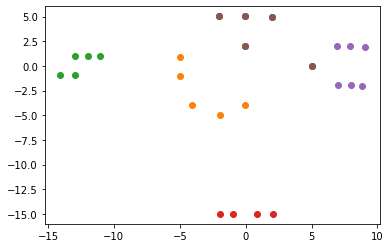

In [52]:
# Grab the indices of the clusters:
depots_vals = [int(val.x) for val in depots]

def clusters(assign_matrix):
    clusts = []
    for j in range(len(depots_vals)):
        if depots_vals[j] == 1: #check if the col of Y is a depot
            clusts.append([])
            for i in range(len(clients)):
                if assign_matrix[i][j] == 1:
                     clusts[-1].append(i)
    return clusts

# Create scatterplot
c = clusters(optY)

X_colors_0 = []
for i in range(len(c)):
    X_colors_0.append([])
    for index in c[i]:
        X_colors_0[i].append(X[0][index])
        
X_colors_1 = []
for i in range(len(c)):
    X_colors_1.append([])
    for index in c[i]:
        X_colors_1[i].append(X[1][index])
         
for i in range(len(X_colors_1)):
    plt.scatter(X_colors_0[i], X_colors_1[i])     

plt.scatter(X_colors_0[0], X_colors_1[0])